## Non-Linear Model

Start with packages

In [157]:
from math import isclose, prod, sqrt
import matplotlib.pyplot as plot
import numpy as np
import random
from random import gauss, randint, uniform
from sklearn.linear_model import LinearRegression
from statistics import mean

Set constants.

Set *masterSeed* to None to make every run different.  Set it to an integer to repeat to get 
the sam results over and over.

Sigma represents the amount of additive noise in the output.

In [158]:
nGene = 4
nSamp = 100

upDownLev = 1

masterSeed = 445  
# masterSeed = None

sigma = 0.1

### Set up the problem

The model assumes that of each gene:
1. Contributors something to the final output
2. That the contributions are additive.
3. That the contributions of each gene are independent of each other.

Writing this model as an algebraic shows that this is equivalent to assuming "the linear model".

In [159]:
if masterSeed is not None:
	seed = masterSeed
else:
	random.seed()
	seed = randint(0, 999)
	
random.seed(seed)
print(f'Seed = {seed}')

Seed = 445


In [160]:
nGene = 4

linWeight = [uniform(-1,1) for _ in range(nGene)]
print(f'weights = {linWeight}')

weights = [0.10164352392380116, -0.5002335298078537, -0.21417753879713186, 0.9390499130926009]


Make a callable function for this model.

In [161]:
def LinMod(weights, inputs):
	assert(len(weights) == len(inputs))
	result = sum((weight*input for (weight,input) in zip(weights,inputs)))
	return result

Create a model for up and down regulation based on pairs of genes

In [162]:
upGroups = [(1,1,0,0), (0,0,1,1)]
downGroups = [(0,1,1,0), (1,0,0,1)]

In [163]:
def UpDownMod(geneSamp, upGroups,downGroups):
	result = 0
	for group in upGroups:
		if all((m and d) or not m for (m,d) in zip(geneSamp,group)):
			result += upDownLev
	for group in downGroups:
		if all((m and d) or not m for (m,d) in zip(geneSamp,group)):
			result -= upDownLev
	return result

Test *UpDownMod*

In [164]:
nCase = 2 ** nGene
allCasesNum = tuple(
	tuple((num & (1 << bNum)) >> bNum for bNum in range(nGene)) 
	for num in range (nCase))

allCasesBool = list(tuple(allCasesNum[i][j] == 1 for j in range(nGene)) for i in range(nCase))
allCasesBool

[(False, False, False, False),
 (True, False, False, False),
 (False, True, False, False),
 (True, True, False, False),
 (False, False, True, False),
 (True, False, True, False),
 (False, True, True, False),
 (True, True, True, False),
 (False, False, False, True),
 (True, False, False, True),
 (False, True, False, True),
 (True, True, False, True),
 (False, False, True, True),
 (True, False, True, True),
 (False, True, True, True),
 (True, True, True, True)]

In [165]:
result = []
for case in allCasesBool:
	result.append((UpDownMod(case, upGroups,downGroups)))
result

[0, 0, 0, 1, 0, 0, -1, 0, 0, -1, 0, 0, 1, 0, 0, 0]

Assume that each gene occurs in the population with a fixed proportion, not necessarily 1/2.

In [166]:
prev = [uniform(0,1) for _ in range(nGene)]
print(f'Prevalence = {prev}')

Prevalence = [0.8899003733505119, 0.4047913222275106, 0.7377358513004266, 0.3113088768178486]


#### Generate Samples

The genes combinations are selected randomly according to the (randomly selected) prevalence
levels for the population.

In [167]:
geneSampBool = tuple(tuple(uniform(0,1) < p for p in prev) for _ in range(nSamp))
print(f'1st sample = {geneSampBool[0]}')
print(f'2nd sample = {geneSampBool[1]}')

1st sample = (True, False, False, False)
2nd sample = (True, True, True, False)


Represent the gene samples numerically (as well as logically), because sometimes it's easier to use.

In [168]:
geneSampNum = tuple(tuple(1 if hasGene else 0 for hasGene in samp) for samp in geneSampBool)
print(f'1st sample = {geneSampNum[0]}')
print(f'2nd sample = {geneSampNum[1]}')

1st sample = (1, 0, 0, 0)
2nd sample = (1, 1, 1, 0)


#### Generate Synthetic Measurements

The ground truth for the quantity to be measured will be the sum the linear model and the up-down 
regulation model.

In [169]:
meas = tuple(
	LinMod(linWeight, gn) + gauss(0,sigma) + UpDownMod(gs,upGroups,downGroups) 
	for (gn,gs) in zip(geneSampNum,geneSampBool))
print(f'1st sample = {meas[0]}')
print(f'2nd sample = {meas[1]}')

1st sample = 0.15494976847007744
2nd sample = -0.6231084450013145


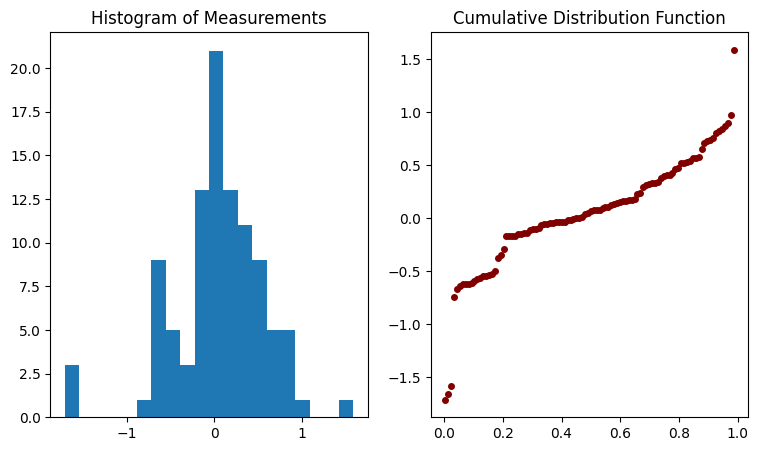

In [170]:
fig, (ax0,ax1) = plot.subplots(1,2, figsize=(9,5))

ax0.hist(meas,bins=20)
ax0.title.set_text('Histogram of Measurements')

x = [(k + 0.5)/(nSamp + 1) for k in range(nSamp)]
ax1.plot(x,sorted(meas), 'o', ms=4, c='maroon')
ax1.title.set_text('Cumulative Distribution Function')

Notice that the variance in measurements is larger, because of the up-down regulation increases 
the spread.

### Learn Module from (i.e., Fit Model to) the Data

In [171]:
x = np.array(geneSampNum)
y = np.array(meas)
print(f'x shape = {x.shape}, y shape = {y.shape}')

x shape = (100, 4), y shape = (100,)


In [172]:
reg = LinearRegression()
reg.fit(x,y)

linFit = reg.coef_
print(f'linear model fit weights:\n  {linFit}')
print(f'Ture weights for linear component:\n  {linWeight}')

linear model fit weights:
  [ 0.43345783 -0.28887029 -0.25364032  0.6340592 ]
Ture weights for linear component:
  [0.10164352392380116, -0.5002335298078537, -0.21417753879713186, 0.9390499130926009]


Notice that the estimation of the linear model is somewhat close to the linear component
of the model.  This is because the linear estimation is blind to the up-down component of the
ground truth and because the effects on the up-down model tend to average out.

Notice also that using a linear model to estimate the linear component of the linear model in
the presence of the up-down phenomena is not nearly as accurate when the up-down phenomena isn't
present.  This is because the up-down phenomena looks like noise to the linear model.

In [173]:
def RmsError(aList,bList):
	assert(len(aList) == len(bList))
	result = sqrt(sum((a-b)**2 for (a,b) in zip(aList,bList)) / len(aList))
	
	return result

In [174]:
RmsError(linFit,linWeight)

0.24967569068511633

Compute the probability of every gene combination

In [175]:
prob = tuple(prod((p if g == 1 else (1 - p) for (p,g) in zip(prev,case))) for case in allCasesNum)
assert(isclose(sum(prob),1))

In [217]:
def PlotColorCoded(data, upGroup,downGroup, mark='o'):
	redData = [d for d in data if (d[2] in upGroup)]
	blueData = [d for d in data if (d[2] in downGroup)]
	greenData = [d for d in data if ((d[2] not in upGroup) and (d[2] not in downGroup))]
	
	redX = [d[0] for d in redData]
	redY = [d[1] for d in redData]
	plot.plot(redX, redY, mark, c='red')
		
	blueX = [d[0] for d in blueData]
	blueY = [d[1] for d in blueData]
	plot.plot(blueX, blueY, mark, c='blue')
	
	greenX = [d[0] for d in greenData]
	greenY = [d[1] for d in greenData]
	plot.plot(greenX, greenY, mark, c='green')

Text(0, 0.5, 'Probability')

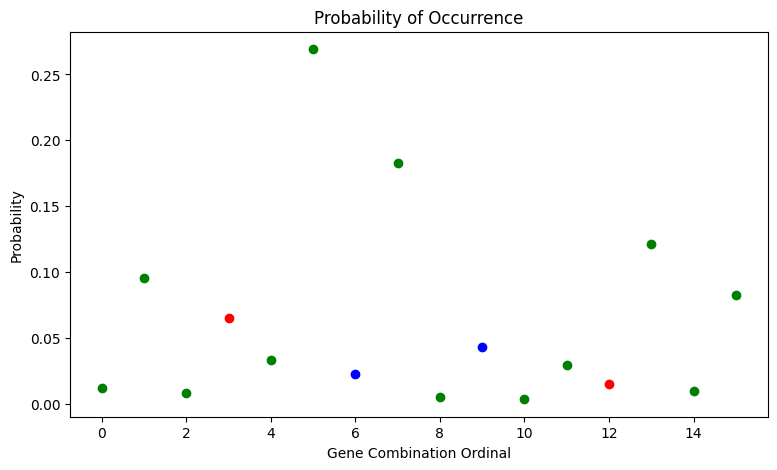

In [218]:
x = [n for n in range(nCase)]
data = list(zip(x,prob,allCasesNum))

plot.subplots(figsize=(9,5))
PlotColorCoded(data, upGroups, downGroups)

plot.title('Probability of Occurrence')
plot.xlabel('Gene Combination Ordinal')
plot.ylabel('Probability')

Red markers correspond to gene combinations that yield up-regulation, the blue markers correspond
to down-regulation, and the green markers to neither.

In [195]:
groundTruth = tuple(LinMod(linWeight, case) for case in allCasesNum)
estMeas = tuple(LinMod(linFit, case) for case in allCasesNum)

In [196]:
error = [(nnm - em, p) for (nnm,em,p) in zip(groundTruth, estMeas, prob)]

The probability weighted mean RMS error

In [197]:
def RmsErrorWeight(aList,bList,weight):
	assert((len(aList) == len(bList)) and (len(bList) == len(weight)))
	totalWeight = sum(weight)
	result = sqrt(sum(w * (a-b)**2 for (a,b,w) in zip(aList,bList,weight)) / totalWeight)
	
	return result

In [198]:
rmsErr = RmsErrorWeight(groundTruth,estMeas,prob)
rmsErr

0.32822463906736526

In [224]:
sigma/rmsErr

0.3046693882706224

Here the RMS error is larger than the measurement noise.  This is because most of the error is 
model mismatch.

## Garbage and Work in Progress

From here on is all stuff that doesn't work.  It's work in progress

In [ ]:
def MeanByGroup(data, group)
	

Text(0, 0.5, 'Quantity to be Measured')

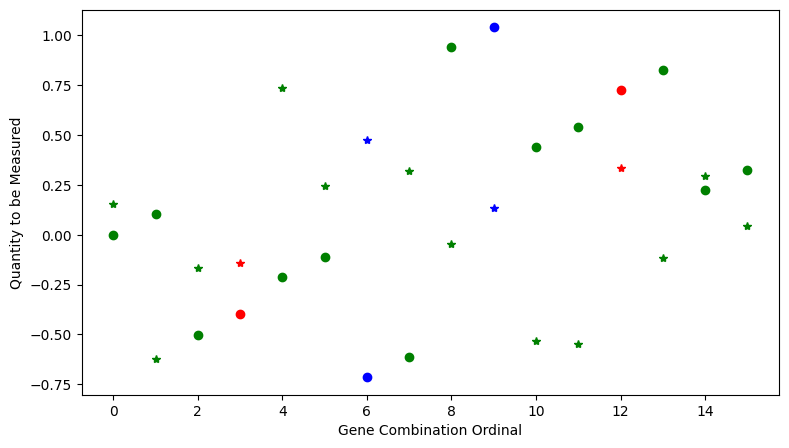

In [219]:
x = [n for n in range(nCase)]

plot.subplots(figsize=(9, 5))

data = list(zip(x, groundTruth, allCasesNum))
PlotColorCoded(data, upGroups, downGroups)

data = list(zip(x, , allCasesNum))
PlotColorCoded(data, upGroups, downGroups, '*')

plot.xlabel('Gene Combination Ordinal')
plot.ylabel('Quantity to be Measured')

In [223]:
len(meas)

100